## Привет

* Тебе предлагается выбрать первую или вторую задачку для решения :)

* Да, можно выбрать и две

* Да, можно решить и бонусную - третью ⛳

**Оформление решения**

colab-notebook, который запускается (или готовый python script)

можно использовать публичный git репозиторий для хранения кода при необходимости (например на github)


**Комментарий**

* В первую очередь будем смотреть на умение разбираться в постановке задачи и писать свой код

* Да, можно пытаться адаптировать какие-то решения

* Тут нет больших датасетов и огромных требований к качеству по метрикам

* Важно скорее предложить релевантную идею и реализовать ее

* Язык python - фреймворки torch и tf (лучше на торче, если не составит дополнительного труда)

## Идентификация спикеров (задача 1)

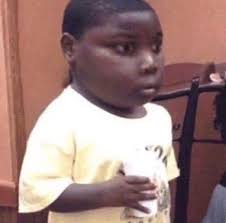


**Цель:**

* Поработать с аудио сигналами
* Показать умение строить и обучать простые модели

**Условие:**

Решить задачу идентификация спикеров по голосу (определения личности говорящего)

**Данные**

В качестве датасета предлагается использовать [VCC2018](https://datashare.ed.ac.uk/handle/10283/3061?show=full)

 В данном датасете всего 8 спикеров: 4 мужчины и 4 женщины

* Для обучения предлагается использовать аудиозаписи из vcc2018_training\VCC2S*

* Для тестирования - из vcc2018_evaluation\*


##  Решение

**Скачайте вспомогательный файл для скачивания данных с google drive**

https://github.com/adelkhalilov/Tinkoff-Lab/blob/main/gfile.py 


####  Все следующие ячейки запускать без изменений, все файлы должны быть доступны для скачиваний

In [4]:
#!L
# import zipfile
import os    
from os import walk
import time
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np
# plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn

import librosa

from gfile import download_list

device = torch.device('cuda:0')
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 1.10.0+cu111
Using GPU


##**Скачивание данных**

In [ ]:
download_list(
    url='https://drive.google.com/file/d/1r139_Kn2Rij9_0p2wnEp8UZMJKcXMLdu/view?usp=sharing',
    filename='vcc2018_database_training.zip',
    target_dir='.'
)

!unzip 'vcc2018_database_training.zip' 

It took  1.45sec to download 117.1 MB vcc2018_database_training.zip 
Archive:  vcc2018_database_training.zip
   creating: vcc2018_training/
   creating: vcc2018_training/VCC2SF3/
  inflating: vcc2018_training/VCC2SF3/20068.wav  
  inflating: vcc2018_training/VCC2SF3/20031.wav  
  inflating: vcc2018_training/VCC2SF3/20039.wav  
  inflating: vcc2018_training/VCC2SF3/20021.wav  
  inflating: vcc2018_training/VCC2SF3/20060.wav  
  inflating: vcc2018_training/VCC2SF3/20005.wav  
  inflating: vcc2018_training/VCC2SF3/20003.wav  
  inflating: vcc2018_training/VCC2SF3/20010.wav  
  inflating: vcc2018_training/VCC2SF3/20044.wav  
  inflating: vcc2018_training/VCC2SF3/20026.wav  
  inflating: vcc2018_training/VCC2SF3/20040.wav  
  inflating: vcc2018_training/VCC2SF3/20062.wav  
  inflating: vcc2018_training/VCC2SF3/20042.wav  
  inflating: vcc2018_training/VCC2SF3/20016.wav  
  inflating: vcc2018_training/VCC2SF3/20017.wav  
  inflating: vcc2018_training/VCC2SF3/20055.wav  
  inflating: vcc2018_

In [ ]:
download_list(
    url='https://drive.google.com/file/d/1VpFh3Jk_4eNlmhjYeXPURQ6eK132cxCB/view?usp=sharing',
    filename='vcc2018_database_evaluation.zip',
    target_dir='.'
)

!unzip './vcc2018_database_evaluation.zip' 

It took  0.61sec to download 31.8 MB vcc2018_database_evaluation.zip 
Archive:  ./vcc2018_database_evaluation.zip
   creating: vcc2018_evaluation/
   creating: vcc2018_evaluation/VCC2SF3/
  inflating: vcc2018_evaluation/VCC2SF3/30023.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30011.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30005.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30008.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30014.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30027.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30004.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30012.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30018.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30026.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30020.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30032.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30009.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30031.wav  
  inflating: vcc2018_evaluation/VCC2SF3/30007.wav  
  inflating: vcc2018_evaluation/

## **Подготовка данных** 


#### Данные скачаны, но в исходном датасете все аудиодорожки лежат по отдельным папкам для каждого спикера. Объединим все директории в train и evaluation частях в единственные директории `vcc2018_training/train` и `vcc2018_evaluation/evaluation` соответственно


In [ ]:
directory = "train"

# Parent Directory path
parent_dir = "./vcc2018_training"

# Path
path_train = os.path.join(parent_dir, directory)

os.mkdir(path_train)

In [ ]:
directory = "evaluation"

parent_dir = "./vcc2018_evaluation"

path_evaluation = os.path.join(parent_dir, directory)

os.mkdir(path_evaluation)

Мы будем предсказывать в качестве метки числа от $0$ до $7$, соотвествующие спикерам из датасета согласно словарю `labels_to_name_mapping`

In [ ]:
labels_to_name_mapping = {
    0 : 'F1', 
    1 : 'F2', 
    2 : 'F3', 
    3 : 'F4', 
    4 : 'M1',
    5 : 'M2',
    6 : 'M3',
    7 : 'M4',
}

In [ ]:
names_to_label_mapping = {val: key for key, val in labels_to_name_mapping.items()}
names_to_label_mapping

{'F1': 0, 'F2': 1, 'F3': 2, 'F4': 3, 'M1': 4, 'M2': 5, 'M3': 6, 'M4': 7}

Скопируем все аудиозаписи в одну папку и добавим в имена аудиофайлов в начало по цифре обозначающей метку спикера 

In [ ]:
import shutil
from shutil import copy

for name_suff in names_to_label_mapping :
    parent_dir = "./vcc2018_training/VCC2S" + name_suff

    cnt = 0
    for f in os.listdir(parent_dir) : 
        if os.path.isfile(os.path.join(parent_dir, f)) :
            new_filename =  str(names_to_label_mapping[name_suff]) + '_' + f
            copy(os.path.join(parent_dir, f), os.path.join(path_train, new_filename)) 
            cnt += 1
    print(cnt)

81
81
81
81
81
81
81
81


In [ ]:
for name_suff in names_to_label_mapping :
    parent_dir = "./vcc2018_evaluation/VCC2S" + name_suff

    cnt = 0
    for f in os.listdir(parent_dir) : 
        if os.path.isfile(os.path.join(parent_dir, f)) :
            new_filename =  str(names_to_label_mapping[name_suff]) + '_' + f
            copy(os.path.join(parent_dir, f), os.path.join(path_evaluation, new_filename)) 
            cnt += 1
    print(cnt)

35
35
35
35
35
35
35
35


##  **Предобработка данных. Извлечение фичей из аудиозаписей**

In [ ]:
#list the files
filelist = os.listdir(path_train) 
#read them into pandas
train_df = pd.DataFrame(filelist)

In [ ]:
train_df

,0
0,7_20053.wav
1,1_10040.wav
2,4_10031.wav
3,4_10003.wav
4,7_20057.wav
...,...
643,1_10074.wav
644,5_10079.wav
645,5_10014.wav
646,3_20006.wav


Как видно названия файлов первым символом содержат label спикера

In [ ]:
train_df = train_df.sort_values(by=[0])
train_df

,0
290,0_10001.wav
520,0_10002.wav
311,0_10003.wav
86,0_10004.wav
14,0_10005.wav
...,...
143,7_20077.wav
89,7_20078.wav
226,7_20079.wav
592,7_20080.wav


In [ ]:
train_df.index = np.arange(0, len(train_df))
train_df

,0
0,7_20053.wav
1,1_10040.wav
2,4_10031.wav
3,4_10003.wav
4,7_20057.wav
...,...
643,1_10074.wav
644,5_10079.wav
645,5_10014.wav
646,3_20006.wav


In [ ]:
train_df = train_df.rename(columns={0:'file'})

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    648 non-null    object
dtypes: object(1)
memory usage: 10.1+ KB


Создадим колонку со значением метки

In [ ]:
# We now assign the speaker to a new column 
train_df['speaker'] = train_df['file'].apply(lambda x : int(x[0]))

In [ ]:
labels_train = np.array(train_df['speaker'])
labels_train

array([7, 1, 4, 4, 7, 1, 0, 0, 3, 1, 0, 2, 1, 0, 0, 6, 2, 2, 2, 0, 5, 3,
       6, 1, 4, 6, 4, 3, 6, 0, 4, 2, 2, 7, 5, 6, 3, 0, 7, 1, 6, 2, 1, 2,
       5, 1, 2, 7, 6, 5, 2, 7, 0, 1, 5, 1, 6, 3, 7, 5, 4, 7, 4, 2, 3, 4,
       3, 4, 6, 4, 2, 6, 6, 0, 0, 3, 1, 3, 6, 7, 7, 0, 7, 6, 4, 4, 0, 4,
       2, 7, 7, 7, 6, 5, 7, 3, 2, 2, 0, 6, 2, 5, 0, 4, 5, 0, 3, 6, 3, 0,
       3, 3, 4, 3, 1, 3, 7, 7, 4, 3, 2, 7, 6, 4, 0, 7, 6, 2, 5, 1, 4, 7,
       5, 5, 1, 3, 0, 6, 0, 7, 2, 3, 6, 7, 1, 5, 3, 4, 2, 2, 1, 0, 6, 6,
       1, 4, 0, 2, 7, 2, 5, 7, 4, 6, 5, 0, 5, 3, 3, 6, 6, 6, 1, 4, 2, 3,
       2, 1, 0, 1, 6, 7, 4, 1, 2, 4, 2, 3, 0, 0, 4, 6, 3, 0, 3, 7, 0, 4,
       5, 4, 0, 2, 1, 5, 5, 0, 6, 3, 4, 0, 6, 4, 3, 7, 3, 6, 5, 1, 3, 1,
       4, 7, 6, 5, 5, 4, 7, 2, 6, 0, 4, 2, 0, 7, 6, 5, 2, 6, 5, 0, 3, 0,
       1, 0, 3, 5, 3, 6, 2, 5, 7, 3, 5, 3, 4, 1, 7, 6, 6, 5, 2, 3, 5, 4,
       2, 7, 1, 5, 2, 4, 5, 2, 4, 1, 3, 7, 0, 2, 3, 6, 1, 7, 3, 4, 5, 2,
       7, 1, 1, 4, 0, 0, 2, 7, 7, 7, 3, 7, 6, 3, 7,

In [ ]:
data_path = './vcc2018_training/train/'

Извлечем фичи из аудиофайлов с помощью библиотеки `librosa`

In [ ]:
def extract_features(files):

# Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath(data_path), str(files.file))
# Loads the audio file as a floating point time series and assigns the default sample rate
# Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

# Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
# Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
# Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
# Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
# Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
# Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)

    return mfccs, chroma, mel, contrast, tonnetz

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_features = train_df.apply(extract_features, axis=1)

In [ ]:
train_features

0      ([-378.03592, 92.72666, 19.311829, 40.690823, ...
1      ([-355.38324, 97.312256, -1.6822536, 19.359892...
2      ([-363.15662, 146.04207, -9.19652, 11.103923, ...
3      ([-290.01202, 129.31093, 5.444868, 17.88983, 2...
4      ([-336.6351, 98.35395, 19.41707, 33.25374, 18....
                             ...                        
643    ([-391.9403, 96.753685, 11.220611, 25.019281, ...
644    ([-287.58667, 112.16736, -12.524475, 27.863607...
645    ([-304.8451, 93.43994, -7.360517, 21.463722, 3...
646    ([-238.91321, 133.77112, -39.52861, 14.875191,...
647    ([-340.2777, 103.581245, 15.970602, 40.119423,...
Length: 648, dtype: object

In [ ]:
summ = 0
for i in range(len(train_features[0])) : 
    print(train_features[0][i].shape)
    summ += len(train_features[0][i])
summ

(40,)
(12,)
(128,)
(7,)
(6,)


193

Для каждой строки (объекта выборки) объединим все получившиеся массивы в один

In [ ]:
train_features_joined = []
for i in range(0, len(train_features)):
    train_features_joined.append(np.concatenate((
        train_features[i][0],
        train_features[i][1], 
        train_features[i][2], 
        train_features[i][3],
        train_features[i][4]), axis=0))

In [ ]:
X_train = np.array(train_features_joined)
X_train

array([[-3.78035919e+02,  9.27266617e+01,  1.93118286e+01, ...,
         2.60107652e-03,  7.12884116e-03,  4.20810976e-03],
       [-3.55383240e+02,  9.73122559e+01, -1.68225360e+00, ...,
         1.89317476e-02, -1.26354065e-02,  4.55404439e-03],
       [-3.63156616e+02,  1.46042068e+02, -9.19651985e+00, ...,
        -8.79406003e-03,  4.65600458e-02,  3.65768619e-03],
       ...,
       [-3.04845093e+02,  9.34399414e+01, -7.36051702e+00, ...,
         1.19021948e-02,  2.90033129e-02, -1.72405767e-02],
       [-2.38913208e+02,  1.33771118e+02, -3.95286102e+01, ...,
        -6.29839821e-02,  1.00526687e-02, -5.96400459e-03],
       [-3.40277710e+02,  1.03581245e+02,  1.59706020e+01, ...,
        -1.01679217e-03, -5.67695341e-03,  3.54554491e-03]])

In [ ]:
X_train.shape

(648, 193)

Повторим те же шаги для evaluation части выборки

In [ ]:
def data_preprocessing(path = './vcc2018_evaluation/evaluation') :
    filelist = os.listdir(path)
    df = pd.DataFrame(filelist)
    df = df.rename(columns={0:'file'})
    df['speaker'] = df['file'].apply(lambda x : int(x[0]))
    labels = np.array(df['speaker'])
    df_features = df.apply(extract_features, axis=1)
    data_features_joined = []

    for i in range(0, len(df_features)):
        data_features_joined.append(np.concatenate((
            df_features[i][0],
            df_features[i][1], 
            df_features[i][2], 
            df_features[i][3],
            df_features[i][4]), axis=0))
    
    X = np.array(data_features_joined)
    return X, labels


In [ ]:
data_path = './vcc2018_evaluation/evaluation'
X_eval, labels_eval = data_preprocessing(path=data_path)

In [ ]:
labels_eval

array([4, 0, 5, 1, 0, 7, 7, 2, 7, 5, 0, 6, 6, 3, 0, 4, 0, 4, 4, 2, 2, 3,
       0, 3, 1, 0, 5, 7, 4, 6, 4, 5, 5, 2, 1, 7, 2, 2, 0, 7, 4, 6, 7, 6,
       1, 1, 1, 3, 0, 3, 4, 6, 7, 1, 0, 0, 7, 3, 0, 7, 1, 1, 0, 7, 4, 0,
       6, 5, 0, 2, 6, 5, 1, 1, 0, 0, 2, 4, 4, 1, 6, 7, 3, 5, 1, 1, 5, 0,
       7, 4, 7, 3, 5, 6, 0, 5, 6, 3, 3, 4, 3, 3, 7, 7, 7, 2, 3, 0, 0, 2,
       4, 3, 1, 7, 5, 3, 0, 7, 6, 6, 3, 6, 0, 5, 6, 5, 4, 2, 7, 2, 5, 2,
       3, 6, 6, 5, 3, 4, 5, 6, 7, 4, 1, 1, 6, 1, 2, 6, 1, 4, 1, 6, 3, 0,
       4, 4, 7, 7, 1, 1, 0, 5, 4, 7, 7, 0, 5, 7, 2, 6, 3, 3, 2, 7, 3, 2,
       2, 1, 3, 6, 2, 1, 2, 4, 6, 6, 4, 5, 3, 5, 6, 3, 4, 5, 2, 6, 5, 7,
       0, 1, 5, 1, 2, 2, 3, 4, 2, 5, 1, 4, 2, 6, 3, 4, 1, 6, 6, 3, 3, 5,
       2, 1, 2, 5, 7, 0, 2, 2, 7, 4, 7, 4, 1, 7, 0, 2, 2, 4, 1, 0, 3, 5,
       3, 2, 4, 5, 5, 2, 5, 5, 3, 7, 5, 7, 0, 4, 7, 1, 5, 2, 4, 6, 0, 6,
       3, 4, 6, 0, 1, 0, 4, 3, 6, 1, 6, 2, 5, 1, 3, 0])

In [ ]:
X_eval.shape

(280, 193)

## **Модель**

In [ ]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Создадим простую модель из чередующихся полносвязных линейных слоев и слоев нелинейности ReLU

In [ ]:
import torch.nn.functional as F
from torch.nn import init

input_size = X_train.shape[1]
output_size = len(labels_to_name_mapping)
# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier2(nn.Module):
    # Еhe model architecture
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048,128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            nn.Tanh()
        )
 
    # Forward pass computations
    def forward(self, x):
        return self.network(x)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Check that it is on Cuda

In [ ]:
class VCDataset(Dataset):

    def __init__(self, df, y) :
        self.data = df
        self.y = y
    def __len__(self) : 
        return len(self.data)

    def __getitem__(self, idx ):
        return self.data[idx], self.y[idx]

In [ ]:
train_dataset = VCDataset(X_train, labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
print("Количество батчей на train части = ", len(train_loader))

Количество батчей на train части =  41


In [ ]:
eval_dataset = VCDataset(X_eval, labels_eval)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=16, shuffle=True)

## **Обучение**

In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, data_loader, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                    steps_per_epoch=int(len(data_loader)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        for i, data in enumerate(data_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            optimizer.zero_grad()

            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)

            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

        # Print stats at the end of the epoch
        num_batches = len(data_loader)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    print('Finished Training')

In [ ]:
# Create the model and put it on the GPU if available
model2 = AudioClassifier2()
model2 = model2.to(device)
next(model2.parameters()).device

device(type='cuda', index=0)

In [ ]:
num_epochs = 100
training(model2, train_loader, num_epochs)

Epoch: 0, Loss: 2.06, Accuracy: 0.21
Epoch: 1, Loss: 1.94, Accuracy: 0.34
Epoch: 2, Loss: 1.58, Accuracy: 0.60
Epoch: 3, Loss: 1.17, Accuracy: 0.81
Epoch: 4, Loss: 0.98, Accuracy: 0.86
Epoch: 5, Loss: 0.85, Accuracy: 0.92
Epoch: 6, Loss: 0.79, Accuracy: 0.93
Epoch: 7, Loss: 0.73, Accuracy: 0.97
Epoch: 8, Loss: 0.70, Accuracy: 0.98
Epoch: 9, Loss: 0.70, Accuracy: 0.99
Epoch: 10, Loss: 0.70, Accuracy: 0.99
Epoch: 11, Loss: 0.69, Accuracy: 0.99
Epoch: 12, Loss: 0.70, Accuracy: 0.99
Epoch: 13, Loss: 0.71, Accuracy: 0.98
Epoch: 14, Loss: 0.68, Accuracy: 1.00
Epoch: 15, Loss: 0.67, Accuracy: 1.00
Epoch: 16, Loss: 0.67, Accuracy: 1.00
Epoch: 17, Loss: 0.67, Accuracy: 1.00
Epoch: 18, Loss: 0.67, Accuracy: 1.00
Epoch: 19, Loss: 0.67, Accuracy: 1.00
Epoch: 20, Loss: 0.71, Accuracy: 0.98
Epoch: 21, Loss: 0.68, Accuracy: 0.99
Epoch: 22, Loss: 0.69, Accuracy: 0.99
Epoch: 23, Loss: 0.67, Accuracy: 1.00
Epoch: 24, Loss: 0.67, Accuracy: 1.00
Epoch: 25, Loss: 0.67, Accuracy: 1.00
Epoch: 26, Loss: 0.67,

In [ ]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  with torch.no_grad():
    for data in val_dl:
      inputs, labels = data[0].to(device), data[1].to(device)

      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      outputs = model(inputs.float())

      _, prediction = torch.max(outputs, 1)

      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.3f}, Total items: {total_prediction}')


In [ ]:
# Run inference on trained model with the validation set
inference(model2, eval_loader)

Accuracy: 1.000, Total items: 280


#### Даже простая модель показывает хорошие результаты

## super resolution (задача 2)

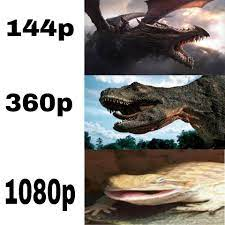


**Цель:**

* Поработать с изображениями
* Показать умение строить и обучать простые модели

**Условие:**

* Попробовать решить задачу увеличения разрешения входного изображения 

* Приветствуется сравнение нейросетевого подхода с классическими методами (линейная, бикубическая интерполяции)


**Данные**

В качестве датасета предлагается использовать [data](https://drive.google.com/file/d/1za24UKmQK8L9QVNaVrlMdyx3URTGMpmL/view?usp=sharing)

 В данном датасете ~100 картинок в низком и высоком разрешении

* Для обучения предлагается самостоятельно разбить датасет на **train** (90%) и **validation** (10%)

In [5]:
!pip install ISR

In [6]:
!pip install 'h5py==2.10.0' --force-reinstall

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you hav

In [7]:
from gfile import download_list

In [8]:
download_list(
    url='https://drive.google.com/file/d/1BPlcAoE4a0lT6vkJLoPVrKmH7kHTYOAx/view?usp=sharing',
    filename='super_resolution.zip',
    target_dir='.'
)

It took  1.41sec to download 27.2 MB super_resolution.zip 


In [9]:
!unzip './super_resolution.zip'

Archive:  ./super_resolution.zip
replace Data/HR/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:
data_len = 100
train_ratio = 0.9

In [11]:
shuffle = np.arange(data_len)
np.random.shuffle(shuffle)
shuffle

array([66,  2, 50, 42, 11, 48, 97, 29, 37, 91, 26,  0, 30, 46, 36, 81, 58,
       21, 73, 79, 31, 98, 14, 89,  9,  4, 76,  8, 32, 47, 99, 25, 93, 75,
        6, 88, 19, 68, 84,  1, 80, 72, 67, 17, 62, 45, 38, 96, 24, 94, 60,
       35, 18, 55, 70,  7, 86, 61,  3, 63, 71, 90, 64, 69, 39, 56, 53, 92,
       65,  5, 59, 87, 57, 33, 34, 43, 54, 52, 22, 83, 10, 77, 44, 28, 51,
       27, 16, 20, 40, 78, 15, 74, 49, 12, 13, 95, 82, 41, 85, 23])

In [12]:
indexes = {}
indexes['train'] = shuffle[:90]
indexes['val'] = shuffle[90:]

In [13]:
len(indexes['train'])

90

In [14]:
def make_directory(directory, parent_dir = './') : 
    path_train = os.path.join(parent_dir, directory)
    os.mkdir(path_train)

In [15]:
import shutil
from shutil import copy

def copy_files(old_dir, new_dir, part = 'train') :
    for f in os.listdir(old_dir) : 
        image_num = int(f[:-4])
        if os.path.isfile(os.path.join(old_dir, f)) and image_num in indexes[part]:
            copy(os.path.join(old_dir, f), os.path.join(new_dir, f)) 

In [16]:
directorys = ['lr_train', 'hr_train', 'lr_val', 'hr_val']

In [ ]:
for dir in directorys :
    make_directory(dir)
    old_dir = './Data/' + dir[:2].upper()
    new_dir = './' + dir
    part = dir[3:]
    copy_files(old_dir, new_dir, part)

In [ ]:
from ISR.models import RRDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19

lr_train_patch_size = 96
layers_to_extract = [5, 9]
scale = 2
hr_train_patch_size = lr_train_patch_size * scale

rrdn  = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale}, patch_size=lr_train_patch_size)
f_ext = Cut_VGG19(patch_size=hr_train_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_train_patch_size, kernel_size=3)

from ISR.train import Trainer

loss_weights = {
  'generator': 0.0,
  'feature_extractor': 0.0833,
  'discriminator': 0.01
}

losses = {
  'generator': 'mae',
  'feature_extractor': 'mse',
  'discriminator': 'binary_crossentropy'
}

log_dirs = {'logs': './logs', 'weights': './weights'}

learning_rate = {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}

flatness = {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}

trainer = Trainer(
    generator=rrdn,
    discriminator=discr,
    feature_extractor=f_ext,
    lr_train_dir='./lr_train',  
    hr_train_dir='./hr_train',
    lr_valid_dir='./lr_val',
    hr_valid_dir='./hr_val',
    loss_weights=loss_weights,
    learning_rate=learning_rate,
    flatness=flatness,
    dataname='image_dataset',
    log_dirs=log_dirs,
    weights_generator=None,
    weights_discriminator=None,
    n_validation=10,
)

trainer.train(
    epochs=1,
    steps_per_epoch=2,
    batch_size=8,
    monitored_metrics={'val_PSNR_Y': 'max'}
)


Training details:
  training_parameters: 
    lr_train_dir: ./lr_train
    hr_train_dir: ./hr_train
    lr_valid_dir: ./lr_val
    hr_valid_dir: ./hr_val
    loss_weights: {'generator': 0.0, 'feature_extractor': 0.0833, 'discriminator': 0.01}
    log_dirs: {'logs': './logs', 'weights': './weights'}
    fallback_save_every_n_epochs: 2
    dataname: image_dataset
    n_validation: 10
    flatness: {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}
    learning_rate: {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}
    adam_optimizer: {'beta1': 0.9, 'beta2': 0.999, 'epsilon': None}
    losses: {'generator': 'mae', 'discriminator': 'binary_crossentropy', 'feature_extractor': 'mse'}
    metrics: {'generator': <function PSNR_Y at 0x7fc79820ac20>}
    lr_patch_size: 96
    steps_per_epoch: 2
    batch_size: 8
    starting_epoch: 0
  generator: 
    name: rrdn
    parameters: {'C': 4, 'D': 3, 'G': 64, 'G0': 64, 'T': 10, 'x': 2}
    weights_generator: Non

Epoch 0/1
Current learning rate: 0.00039999998989515007
  0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
lr_img = Image.open('./lr_val/13.png')
lr_img = np.array(img)

sr_img = rrdn.predict(lr_img)
Image.fromarray(sr_img)

NameError: ignored

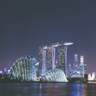

In [45]:
import numpy as np
from PIL import Image

lr_img = Image.open('./lr_val/13.png')
img

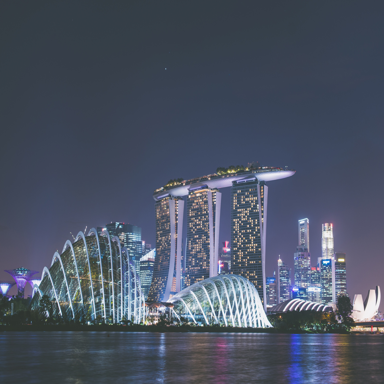

In [25]:
img_hr = Image.open('./hr_val/13.png')
img_hr

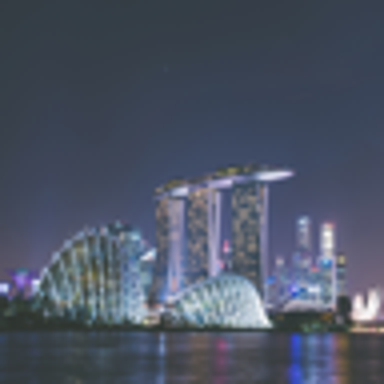

In [41]:
img.resize(size=(img_hr.size[0], img_hr.size[1]), resample=Image.BICUBIC)

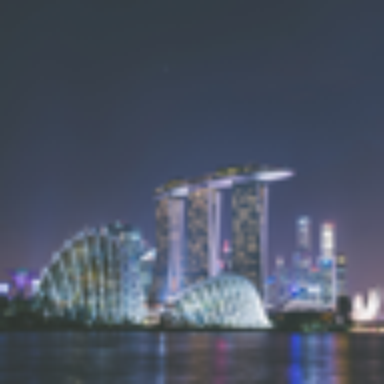

In [43]:
img.resize(size=(img_hr.size[0], img_hr.size[1]), resample=Image.BILINEAR)

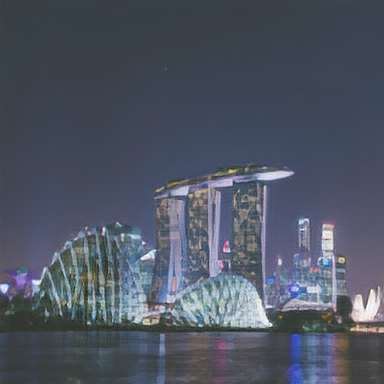

In [47]:
from ISR.models import RRDN

lr_img = np.array(img)

model_rrdn = RRDN(weights='gans')
sr_img = model_rrdn.predict(lr_img)
Image.fromarray(sr_img)

ValueError: ignored

## На подумать (задача 3)

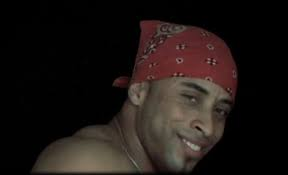

**Условие - ниже :)**

**Данные**

[data](https://drive.google.com/drive/folders/1_i00deQlwQrNxiv0R8XhmIGtaDGzLbgP?usp=sharing)


#### Сначала создадим простенькую модельку без смысловой нагрузки

In [ ]:
import torch 
import torch.nn as nn
import numpy as np
from tqdm import tqdm


# create simple model with one conv2d layer

class SimpleModel(nn.Module):
  def __init__(self):
    super(SimpleModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3))
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3))
    
    self.act1 = nn.Sigmoid()
    self.act2 = nn.Sigmoid()

  def forward(self, data):
    out = self.conv1(data)
    out = self.act1(out)
    out = self.conv2(out)
    out = self.act2(out)

    return out  

#### создадим инстанс модельки и положим ее на карточку

In [ ]:
# create gpu device
device = torch.device('cuda')

# create model instance
model = SimpleModel()
model = model.to(device)

#### Так выглядит первый способ получения батча данных

In [ ]:
def get_sample_1():
  data = torch.load("/content/data1.pt")
  
  return data

#### Прогоним в цикле сетку и измерим время

можно измерить время на втором запуске ячейки после "прогрева" сетки

In [ ]:
%%time
data = get_sample_1()
print("shape", data.shape)

for i in tqdm(range(150)):
  input = torch.clone(data)
  out = model.forward(input.to(device))

#### Так выглядит второй способ получения батча данных

In [ ]:
def get_sample_2():
  data = torch.load("/content/data2.pt")
  
  return data

#### Прогоним в цикле сетку и измерим время

In [ ]:
%%time

data = get_sample_2()
print("shape", data.shape)

for i in tqdm(range(150)):
  input = torch.clone(data)
  out = model.forward(input.to(device))

#### Вопрос, почему так отличается скорость ?

#### Если будут вопросы по условию можно писать мне [tg Dima](https://t.me/DmitryGadecky)